In [142]:
import torch
from trainer import *
from torch.utils.data import DataLoader
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from models.CNN import *
from sklearn.metrics import r2_score


# Предобработка данных

In [143]:
compr_data_path = r"..\..\data\PDMS\Compression_pdms.csv"
tensl_data_path = r"..\..\data\PDMS\Shear_pdms.csv"
shear_data_path = r"..\..\data\PDMS\Tensile_pdms.csv"
experiments_path = [compr_data_path, tensl_data_path, shear_data_path]

In [144]:
data_frames = [pd.read_csv(file, header=None) for file in experiments_path]
df = pd.concat(data_frames, ignore_index=True)
thinned_data_frames = []
num_points = 50

sampled_df_list = []

for df in data_frames:
    indices = np.linspace(0, len(df) - 1, num_points, dtype=int)
    df[1] = df[1] / 10**3
    sampled_df = pd.DataFrame(df.iloc[indices].copy())
    # print(type(sampled_df))
    sampled_df_list.append(sampled_df)
    # thinned_df = df.iloc[::len(df) // 20, :]  # Выбор каждого 45-го значения
    # thinned_data_frames.append(thinned_df)
data_frames = sampled_df_list

# sampled_df_list[0]


In [145]:
I1_tc = lambda lam: lam ** 2 + 2.0 / lam
I2_tc = lambda lam: 2.0 * lam + 1 / lam ** 2
I1_s = lambda gam: gam ** 2 + 3.0
F_tc = lambda lam: ([lam, 0, 0], [0, lam - 0.5, 0], [0, 0, lam - 0.5])
F_s = lambda gam: ([1., gam, 0], [0, 1., 0], [0, 0, 1.])


In [146]:
mechanical_variables = {
    "I1": [I1_tc, I1_s],
    "I2": [I2_tc, I1_s],
    "F": [F_tc, F_s],
    # "exp_type": [(lambda x: 1), (lambda x: 0)] # 1 - torsion&compression, 0 - shear
    # "torsion_compression": (lambda x: 1)
}

# calculate I1, I2, F from lambda (torsion&compression and shear)
for variable in mechanical_variables.keys():
    func_calc = mechanical_variables.get(variable)

    data_frames[0][variable] = data_frames[0][0].apply(func_calc[0])
    data_frames[1][variable] = data_frames[1][0].apply(func_calc[0])
    data_frames[2][variable]  = data_frames[2][0].apply(func_calc[1])


In [147]:
experiments = ['Compression', 'Tensile', 'Shear']
combined_data = pd.concat([df.assign(Experiment=exp) for df, exp in zip(data_frames, experiments)]).reset_index(drop=True, inplace=False)
combined_data.columns = ['lambda', 'P_experimental', 'I1', 'I2', 'F', 'experiment_type']

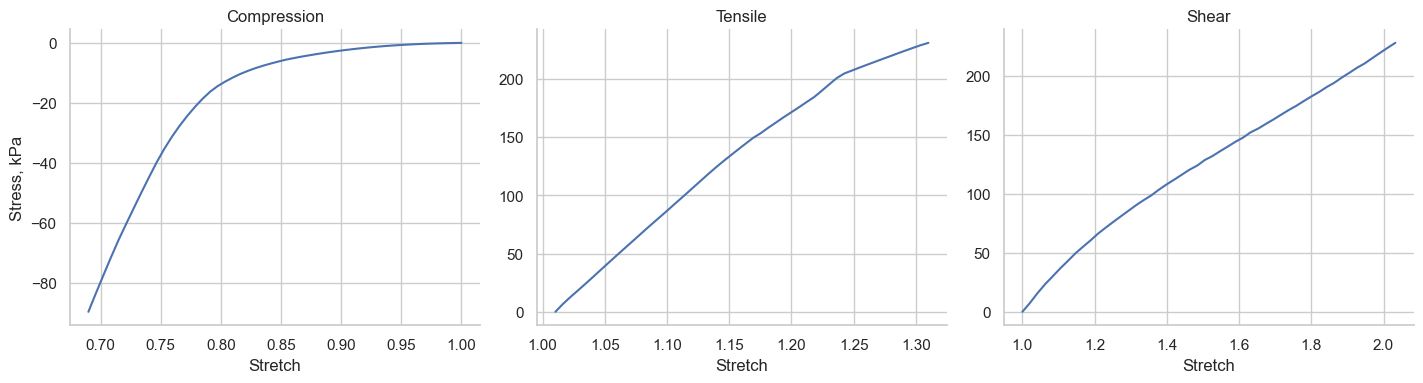

In [148]:
sns.set(style="whitegrid")
g = sns.relplot(
    data=combined_data,
    x='lambda', y='P_experimental', col='experiment_type', kind='line', height=4, aspect=1.2, facet_kws={'sharey': False, 'sharex': False}
)

# Update axis labels
g.set_axis_labels("Stretch", "Stress, kPa")
g.set_titles("{col_name}")
plt.show()

In [149]:
combined_data

,lambda,P_experimental,I1,I2,F,experiment_type
0,0.689936,-89.636249,3.374831,3.480661,"([0.689936, 0, 0], [0, 0.189936, 0], [0, 0, 0....",Compression
1,0.696069,-83.561705,3.357790,3.456069,"([0.6960692, 0, 0], [0, 0.19606920000000005, 0...",Compression
2,0.702543,-77.319573,3.340368,3.431155,"([0.702543, 0, 0], [0, 0.20254300000000003, 0]...",Compression
3,0.708676,-71.499856,3.324385,3.408504,"([0.7086762, 0, 0], [0, 0.20867619999999998, 0...",Compression
4,0.715150,-65.572652,3.308056,3.385565,"([0.71515, 0, 0], [0, 0.21514999999999995, 0],...",Compression
...,...,...,...,...,...,...
145,1.947456,210.570000,6.792585,6.792585,"([1.0, 1.947456, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
146,1.968795,215.110000,6.876153,6.876153,"([1.0, 1.9687949, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
147,1.990134,219.540000,6.960633,6.960633,"([1.0, 1.9901338, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
148,2.011473,223.910000,7.046023,7.046023,"([1.0, 2.0114728, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear


In [150]:
from torch.utils.data import DataLoader, random_split, Dataset, TensorDataset
import copy 

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        # self.features = [dataframe[0],dataframe[2], dataframe[3], dataframe[4], dataframe[5]]
        # self.targets  = dataframe[1]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = copy.deepcopy([*self.data.iloc[idx]])
        target = features.pop(1)

        return features, target

    def to_tensor(self):
        for column in self.data.columns[:-1]:
            self.data[column] = self.data[column].apply(
                lambda x: torch.tensor(x, dtype=torch.float32)).copy()


In [151]:
start = 0
end = -1
train_dataset = CustomDataset(combined_data[start:end].copy())
test_dataset = CustomDataset(combined_data.copy())
f, t = train_dataset[0]
lam, i1, i2, F, exp_type = f
print(f)

[0.689936, 3.374831284754612, 3.4806607692906386, ([0.689936, 0, 0], [0, 0.189936, 0], [0, 0, 0.189936]), 'Compression']


In [152]:
train_dataset.to_tensor()
test_dataset.to_tensor()

train_data_loader = DataLoader(
                        train_dataset,
                        shuffle=True,
                        # num_workers=1,
                        pin_memory=False
)
test_data_loader = DataLoader(
                        test_dataset,
                        shuffle=False,
                        # num_workers=1,
                        pin_memory=False
)

In [153]:
test_data_loader.dataset.data

,lambda,P_experimental,I1,I2,F,experiment_type
0,tensor(0.6899),tensor(-89.6362),tensor(3.3748),tensor(3.4807),"[[tensor(0.6899), tensor(0.), tensor(0.)], [te...",Compression
1,tensor(0.6961),tensor(-83.5617),tensor(3.3578),tensor(3.4561),"[[tensor(0.6961), tensor(0.), tensor(0.)], [te...",Compression
2,tensor(0.7025),tensor(-77.3196),tensor(3.3404),tensor(3.4312),"[[tensor(0.7025), tensor(0.), tensor(0.)], [te...",Compression
3,tensor(0.7087),tensor(-71.4999),tensor(3.3244),tensor(3.4085),"[[tensor(0.7087), tensor(0.), tensor(0.)], [te...",Compression
4,tensor(0.7151),tensor(-65.5727),tensor(3.3081),tensor(3.3856),"[[tensor(0.7151), tensor(0.), tensor(0.)], [te...",Compression
...,...,...,...,...,...,...
145,tensor(1.9475),tensor(210.5700),tensor(6.7926),tensor(6.7926),"[[tensor(1.), tensor(1.9475), tensor(0.)], [te...",Shear
146,tensor(1.9688),tensor(215.1100),tensor(6.8762),tensor(6.8762),"[[tensor(1.), tensor(1.9688), tensor(0.)], [te...",Shear
147,tensor(1.9901),tensor(219.5400),tensor(6.9606),tensor(6.9606),"[[tensor(1.), tensor(1.9901), tensor(0.)], [te...",Shear
148,tensor(2.0115),tensor(223.9100),tensor(7.0460),tensor(7.0460),"[[tensor(1.), tensor(2.0115), tensor(0.)], [te...",Shear


In [ ]:
test_train = Trainer(
    plot_valid=False,
    epochs=3000,
    experiment_name="PDMS_full",
    l2_reg_coeff=0.01,
    learning_rate=0.001,
    checkpoint=None,
    model=StrainEnergyCANN_polinomial3
)

trained_model = test_train.train(train_data_loader, None, weighting_data=False)
# trained_model = StrainEnergyCANN_C()
# trained_model.load_state_dict(torch.load(best_model_path))
trained_model.eval()
vpredictions = []
vtargets = []
for data in test_data_loader:
    features, target = data
    vpredictions.append(trained_model(features).detach().numpy())
print(trained_model.get_potential())
combined_data["P_model"] = vpredictions
# print("R2:", r2_score_own(vtargets, vpredictions))
# plt.figure(figsize=(10, 5))
# plt.plot(vpredictions, label='P_pred', color='red')
# plt.plot(vtargets, label='P_true', color='black')
# plt.xlabel('lambda/gamma')
# plt.ylabel('P')
# plt.title('Predictions vs. Targets')
# plt.legend()

# plt.show()

Directory pretrained_models\PDMS_full created successfully

Epoch [1/3000], Loss: 140941.69081919, Test metric: 945.91738805
Saved PyTorch Model State to pretrained_models\PDMS_full\20240519_1400_0.pth
psi =   0.89 * (I1 - 3) \\               + 5.43 * (I1 - 3) ^ 2 \\               + 2.29 * (I1 - 3) ^ 3 \\                               + 6.69 * (I2 - 3) \\               + 19.96 * (I2 - 3) ^ 2 \\               + 1.08 * (I2 - 3) ^ 3 \\

Epoch [2/3000], Loss: 120582.72839816, Test metric: 809.28005636
Saved PyTorch Model State to pretrained_models\PDMS_full\20240519_1400_1.pth
psi =   0.60 * (I1 - 3) \\               + 5.18 * (I1 - 3) ^ 2 \\               + 2.06 * (I1 - 3) ^ 3 \\                               + 6.37 * (I2 - 3) \\               + 19.47 * (I2 - 3) ^ 2 \\               + 0.89 * (I2 - 3) ^ 3 \\

Epoch [3/3000], Loss: 102893.25302979, Test metric: 690.55874517
Saved PyTorch Model State to pretrained_models\PDMS_full\20240519_1400_2.pth
psi =   0.37 * (I1 - 3) \\               +

In [ ]:
data = combined_data

# Переименуем столбцы для удобства
# data.columns = ['strain', 'measured_force', 'I1', 'I2', 'F', 'experiment_type', 'predicted_force']

# Удалим ненужные столбцы
# data = data[['strain', 'measured_force', 'experiment_type', 'predicted_force']]

# Преобразуем столбец с предсказанной силой в числовой формат
data['P_model'] = data['P_model'].apply(lambda x: float(str(x).strip('[]')))

# Создадим графики для каждого типа эксперимента
experiment_types = data['experiment_type'].unique()
def plot_with_r2(data, experiment_types):
    r2_scores = []
    fig, axes = plt.subplots(1, len(experiment_types), figsize=(15, 6), sharey=True)
    
    for ax, experiment in zip(axes, experiment_types):
        subset = data[data['experiment_type'] == experiment]
        r2 = r2_score(subset['P_experimental'], subset['P_model'])
        
        sns.scatterplot(data=subset, x='lambda', y='P_experimental', label='P_experimental', ax=ax)
        sns.lineplot(data=subset, x='lambda', y='P_model', label='P_model', color='orange', ax=ax)
        ax.set_title(f'Experiment Type: {experiment}\nR² = {r2:.2f}')
        ax.set_xlabel('Strain')
        ax.set_ylabel('Force (kPa)')
        r2_scores.append(r2)

    plt.tight_layout()
    plt.show()
    return r2_scores
# Вызовем функцию для построения графиков с r2
plot_with_r2(data, experiment_types)

In [ ]:
data = combined_data

# Переименуем столбцы для удобства
# data.columns = ['strain', 'measured_force', 'I1', 'I2', 'F', 'experiment_type', 'predicted_force']

# Удалим ненужные столбцы
# data = data[['strain', 'measured_force', 'experiment_type', 'predicted_force']]

# Преобразуем столбец с предсказанной силой в числовой формат
data['P_model'] = data['P_model'].apply(lambda x: float(str(x).strip('[]')))

# Создадим графики для каждого типа эксперимента
experiment_types = data['experiment_type'].unique()
# for experiment in experiment_types:
#     plt.figure(figsize=(10, 6))
#     sns.scatterplot(data=data[data['experiment_type'] == experiment], x='strain', y='measured_force', label='Measured Force')
#     sns.lineplot(data=data[data['experiment_type'] == experiment], x='strain', y='predicted_force', label='Predicted Force', color='orange')
#     plt.title(f'Experiment Type: {experiment}')
#     plt.xlabel('Strain')
#     plt.ylabel('Force (kPa)')
#     plt.legend()
#     plt.show()
# Построим все графики в один ряд
fig, axes = plt.subplots(1, len(experiment_types), figsize=(15, 6), sharey=True)

for ax, experiment in zip(axes, experiment_types):
    sns.scatterplot(data=data[data['experiment_type'] == experiment], x='lambda', y='P_experimental', label='Measured Force', ax=ax)
    sns.lineplot(data=data[data['experiment_type'] == experiment], x='lambda', y='predicted_force', label='Predicted Force', color='orange', ax=ax)
    ax.set_title(f'Experiment Type: {experiment}')
    ax.set_xlabel('Strain')
    ax.set_ylabel('Force (kPa)')

plt.tight_layout()
plt.show()

In [ ]:
# test_train.visualize_predictions(combined_data, data_predictions)
# Построение графиков
sns.set(style="whitegrid")

g = sns.relplot(
    data=combined_data,
    x=0, y=1, col='Experiment', kind='line', height=4, aspect=1.2, facet_kws={'sharey': False, 'sharex': False}
)

# Построение исходных данных
# g = sns.relplot(
#     data=combined_data,
#     x=0, y=1, col='Experiment', kind='line', height=4, aspect=1.2, facet_kws={'sharey': False, 'sharex': False}
# )

# Наложение графиков предсказаний
for ax, experiment in zip(g.axes.flat, ['Compression', 'Tensile', 'Shear']):
    sns.lineplot(data=data_predictions[data_predictions['Experiment'] == experiment], x=0, y='predictions', ax=ax, color='r', label='Prediction')

# Обновляем подписи осей и заголовки
g.set_axis_labels("Stretch", "Stress, kPa")
g.set_titles("{col_name}")

# Показываем графики
plt.show()

In [ ]:
best_model_path = r"pretrained_models\PDMS_6term\20240516_213016_876.pth"
trained_model = StrainEnergyCANN_C()
trained_model.load_state_dict(torch.load(best_model_path))
trained_model.eval()
vpredictions = []
vtargets = []
for data in test_data_loader:
    features, target = data
    # if features[-1] == 1.5:
    vpredictions.append(trained_model(features).detach().numpy())
    vtargets.append(target.detach().numpy())
print(trained_model.get_potential())
print(r2_score_own(vtargets, vpredictions))
plt.figure(figsize=(10, 5))
plt.plot(vpredictions, label='P_pred', color='red')
plt.plot(vtargets, label='P_true', color='black')
plt.xlabel('lambda/gamma')
plt.ylabel('P')
plt.title('Predictions vs. Targets')
plt.legend()
plt.show()

In [ ]:
best_model_path = r"pretrained_models\test\20240518_1901_1000.pth"
trained_model = StrainEnergyCANN_polinomial3()
trained_model.load_state_dict(torch.load(best_model_path))
trained_model.eval()
vpredictions = []
vtargets = []
for data in test_data_loader:
    features, target = data
    # if features[-1] == 1.5:
    vpredictions.append(trained_model(features).detach().numpy())
    vtargets.append(target.detach().numpy())
print(trained_model.get_potential())
print(r2_score_own(vtargets, vpredictions))
plt.figure(figsize=(10, 5))
plt.plot(vpredictions, label='P_pred', color='red')
plt.plot(vtargets, label='P_true', color='black')
plt.xlabel('lambda/gamma')
plt.ylabel('P')
plt.title('Predictions vs. Targets')
plt.legend()
plt.show()

In [ ]:
best_model_path = r"pretrained_models\PDMS_test\20240516_204414_1600.pth"
trained_model = StrainEnergyCANN_polinomial3()
trained_model.load_state_dict(torch.load(best_model_path))
trained_model.eval()
vpredictions = []
vtargets = []
for data in test_data_loader:
    features, target = data
    # if features[-1] == 1.5:
    vpredictions.append(trained_model(features).detach().numpy())
    vtargets.append(target.detach().numpy())
print(trained_model.get_potential())
print(r2_score_own(vtargets, vpredictions))
plt.figure(figsize=(10, 5))
plt.plot(vpredictions, label='P_pred', color='red')
plt.plot(vtargets, label='P_true', color='black')
plt.xlabel('lambda/gamma')
plt.ylabel('P')
plt.title('Predictions vs. Targets')
plt.legend()
plt.show()

In [ ]:
# main()